In [40]:
import pandas as pd
import numpy as np
import warnings
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

import sys
sys.path.append("..")

from plotting_tools import * 

In [41]:
memilio_pop = "pop8"
plot_path = f"../plots/Figure_6"
os.makedirs(plot_path, exist_ok=True)

In [42]:
person_locs = pd.read_csv("../../../preprocessing/data/1_persons_locs.csv", sep=",", dtype=str)

person_locs['WorkSize'] = person_locs.groupby('Work')['Id'].transform('count')
person_locs.loc[person_locs['Work'] == str(-1), 'WorkSize'] = np.nan

person_locs['SchoolSize'] = person_locs.groupby('School')['Id'].transform('count')
person_locs.loc[person_locs['School'] == str(-1), 'SchoolSize'] = np.nan

person_locs['HomeSize'] = person_locs.groupby('Home')['Id'].transform('count')

person_locs['ShopSize'] = person_locs.groupby('Shop')['Id'].transform('count')

person_locs['SocialSize'] = person_locs.groupby('Event')['Id'].transform('count')

In [43]:
loc_mapping = pd.read_csv("../../../preprocessing/data/1_mapping_tan_locs.txt", sep=r"\s+", dtype=str, header=None).iloc[:, [0, 1]]
loc_mapping.columns = ["ABM_id", "tan_id"]
loc_mapping_dict = loc_mapping.set_index("ABM_id")["tan_id"].to_dict()
person_locs["Home_ww_area"] = person_locs["Home"].map(loc_mapping_dict)

In [44]:
warnings.filterwarnings('ignore')

ts = 2208
def find_inf_agents(memilio_id):
    df = pd.read_csv(f"../../../raw_memilio_data/new_est/{memilio_pop}/inf_paths/{memilio_id}_infection_paths.txt", sep=r"\s+", index_col=False)
    
    df["is_inf"] = np.where(df['S'] < ts, 1, 0)
    df["sim"] = memilio_id
    
    return df[["Agent_id", "is_inf", "sim"]]

inf_agents = pd.concat([find_inf_agents(memilio_id) for memilio_id in range(1, 101)])

In [45]:
inf_probs = inf_agents.groupby('Agent_id')['is_inf'].mean().reset_index().rename(columns={'is_inf': 'inf_prob'})
inf_probs['Agent_id'] = inf_probs['Agent_id'].apply(str)

In [46]:
inf_probs_merged = pd.merge(person_locs, inf_probs, left_on='Id', right_on='Agent_id', how='left')
inf_probs_merged = inf_probs_merged[["Agent_id", "WorkSize", "SchoolSize", "HomeSize", "ShopSize", "SocialSize", "inf_prob"]]

In [47]:
inf_probs_merged_filtered = inf_probs_merged[['WorkSize', 'inf_prob']].dropna()
r, p_value = pearsonr(inf_probs_merged_filtered['WorkSize'], inf_probs_merged_filtered['inf_prob'])
print(f"Pearson correlation coefficient: {r:.2f}")
print(f"P-value: {p_value:.3e}")

rho, p_value_rho = spearmanr(inf_probs_merged_filtered['WorkSize'], inf_probs_merged_filtered['inf_prob'])
print(f"Spearman correlation coefficient: {rho:.2f}")
print(f"P-value: {p_value_rho:.3e}")

Pearson correlation coefficient: 0.48
P-value: 0.000e+00
Spearman correlation coefficient: 0.52
P-value: 0.000e+00


In [48]:
inf_probs_summary = inf_probs_merged.groupby("WorkSize")["inf_prob"].agg(mean='mean', p05=lambda x: np.percentile(x, 5), p95=lambda x: np.percentile(x, 95)).reset_index()
asym_error = [inf_probs_summary["mean"] - inf_probs_summary["p05"], inf_probs_summary["p95"] - inf_probs_summary["mean"]]

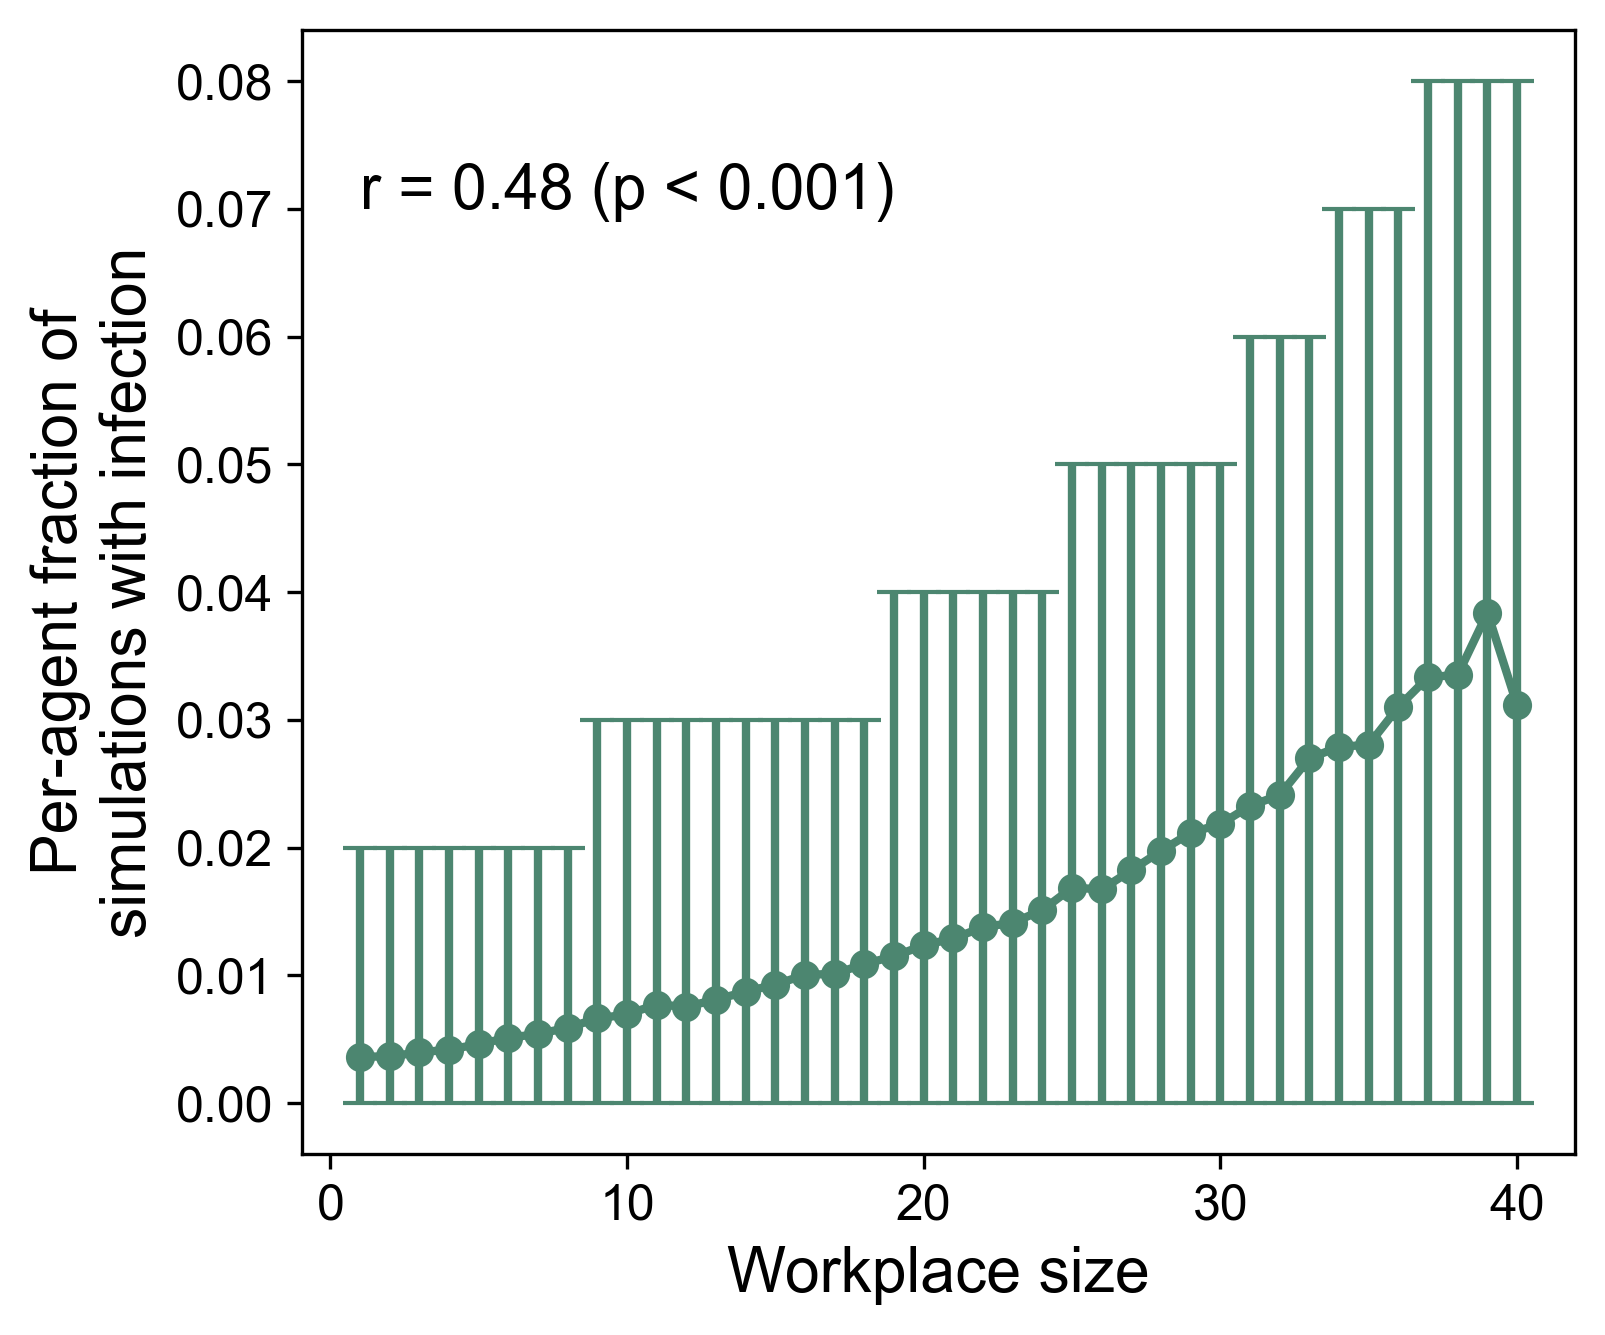

In [49]:
plt.style.use('default')
set_fontsize()

fig, ax = plt.subplots(figsize=(5.6, 4.7), dpi=300)

ax.errorbar(x = inf_probs_summary["WorkSize"], y= inf_probs_summary["mean"], yerr = asym_error, fmt='o-', capsize=4, color='#4C8670', ecolor='#4C8670', linewidth=2)
ax.set_ylabel("Per-agent fraction of\nsimulations with infection")
ax.set_xlabel("Workplace size")

ax.text(1, 0.07, f"r = {r:.2f} (p < 0.001)", fontsize = 15)

plt.tight_layout()
plt.savefig(f"{plot_path}/inf_by_work_size.png", dpi=300)
plt.show()

In [50]:
persons = pd.read_csv("../../../preprocessing/data/persons_scaled.csv", sep=",")

In [51]:
loc_mapping = pd.read_csv("../../../preprocessing/data/1_mapping_tan_locs.txt", sep=r"\s+", dtype=str, header=None).iloc[:, [0, 1]]
loc_mapping.columns = ["ABM_id", "tan_id"]
loc_mapping_dict = loc_mapping.set_index("ABM_id")["tan_id"].to_dict()

In [52]:
person_locs["Home_ww_area"] = person_locs["Home"].map(loc_mapping_dict)
person_locs["Work_ww_area"] = person_locs["Work"].map(loc_mapping_dict)
person_locs["School_ww_area"] = person_locs["School"].map(loc_mapping_dict)
person_locs["Shop_ww_area"] = person_locs["Shop"].map(loc_mapping_dict)
person_locs["Social_ww_area"] = person_locs["Event"].map(loc_mapping_dict)
person_locs["age"] = persons["age"]

In [89]:
person_locs["is_child"] = person_locs['age'].between(5, 15, inclusive = "both")
ww_areas = person_locs.groupby('Home_ww_area')['is_child'].mean().reset_index()

In [90]:
person_locs["is_worker"] = person_locs['age'].between(16, 59, inclusive = "both")
temp = person_locs.groupby('Home_ww_area')['is_worker'].mean().reset_index()
ww_areas = pd.merge(ww_areas, temp, on="Home_ww_area", how="left")
ww_areas.rename(columns={'Home_ww_area': 'ww_area', "is_child": "child_prop", "is_worker": "worker_prop"}, inplace=True)

In [91]:
mean_loc_sizes = person_locs.groupby('Home_ww_area')[['HomeSize', 'WorkSize', 'SchoolSize', 'SocialSize', 'ShopSize']].mean().reset_index()
ww_areas = pd.merge(ww_areas, mean_loc_sizes, left_on='ww_area', right_on='Home_ww_area', how='left')
ww_areas = ww_areas[["ww_area", "child_prop", "worker_prop", "HomeSize", "WorkSize", "SchoolSize", "SocialSize", "ShopSize"]].rename(columns={"WorkSize": "Res_WorkSize", "ShopSize": "Res_ShopSize", "SchoolSize": "Res_SchoolSize", "SocialSize": "Res_SocialSize"})

In [92]:
hospitals = loc_mapping[loc_mapping['ABM_id'].str.match(r'^05', na = False)].groupby('tan_id')['ABM_id'].count()
ww_areas = pd.merge(ww_areas, hospitals, left_on='ww_area', right_on='tan_id', how='left').rename(columns={'ABM_id': 'num_hosp'})
ww_areas["num_hosp"] = ww_areas["num_hosp"].fillna(0)

In [93]:
prev_by_area = pd.read_csv(f"../../../raw_memilio_data/new_est/{memilio_pop}/num_agents_infections_area.txt", sep=",") 
prev_by_area["prev"] = prev_by_area["NumInfected"] / prev_by_area["NumAgents"]
prev_by_area["area"] = prev_by_area["area"].apply(str) 

In [94]:
mean_prev_per_sim = prev_by_area.groupby(['Sim', 'area'])['prev'].mean().reset_index() # or max!
mean_mean_prev = mean_prev_per_sim.groupby(['area'])['prev'].mean().reset_index()

In [95]:
print(set(ww_areas['ww_area']) - set(mean_mean_prev['area']))
ww_areas = pd.merge(ww_areas, mean_mean_prev, left_on='ww_area', right_on='area', how='left')
ww_areas.head()

set()


,ww_area,child_prop,worker_prop,HomeSize,Res_WorkSize,Res_SchoolSize,Res_SocialSize,Res_ShopSize,num_hosp,area,prev
0,1,0.103900,0.581337,2.265460,24.025635,44.252011,220.569220,106.235237,1.0,1,0.001302
1,10,0.105808,0.587879,2.263636,27.745275,43.983294,238.420960,141.583333,0.0,10,0.001588
2,100,0.090237,0.580475,2.203166,25.100000,44.087719,146.422691,230.258575,0.0,100,0.001302
3,101,0.099563,0.582684,2.266093,25.344435,43.888813,166.707804,171.960435,0.0,101,0.001334
4,102,0.100376,0.584861,2.259050,29.895297,43.998829,369.550423,244.966385,0.0,102,0.002453


In [96]:
ww_areas_normalized = ww_areas.copy()
numeric_cols = ww_areas_normalized.select_dtypes(include=[np.number]).columns
ww_areas_normalized[numeric_cols] = (ww_areas_normalized[numeric_cols] - ww_areas_normalized[numeric_cols].min()) / (ww_areas_normalized[numeric_cols].max() - ww_areas_normalized[numeric_cols].min())
ww_areas_normalized.head()

,ww_area,child_prop,worker_prop,HomeSize,Res_WorkSize,Res_SchoolSize,Res_SocialSize,Res_ShopSize,num_hosp,area,prev
0,1,0.201923,0.323531,0.563075,0.151477,0.661868,0.182682,0.006336,0.333333,1,0.068790
1,10,0.216458,0.344792,0.556671,0.483659,0.540393,0.222355,0.060312,0.000000,10,0.186427
2,100,0.097866,0.320729,0.344268,0.247423,0.587599,0.017900,0.195718,0.000000,100,0.068827
3,101,0.168890,0.327909,0.565299,0.269252,0.497682,0.062981,0.106698,0.000000,101,0.082236
4,102,0.175086,0.334985,0.540562,0.675666,0.547416,0.513775,0.218176,0.000000,102,0.541530


In [97]:
X = ww_areas_normalized.drop(columns=["ww_area", "area", "prev"]) 
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data[vif_data["feature"] != "const"])

          feature       VIF
1      child_prop  1.384250
2     worker_prop  1.204056
3        HomeSize  1.282923
4    Res_WorkSize  1.732831
5  Res_SchoolSize  1.221379
6  Res_SocialSize  1.234793
7    Res_ShopSize  1.738224
8        num_hosp  1.048921


In [98]:
# child_prop: proportion of agents living in the ww area who are children
# worker_prop: proportion of agents living in the ww area who are working-age adults
# HomeSize: Mean household size in the area
# Res_WorkSize: Mean size of the workplaces of the area's working-age residents
# Res_SchoolSize: Mean size of the schools of the area's school-age residents
# Res_SocialSize: Mean size of the social events of the area's residents
# Res_ShopSize: Mean size of the shops of the area's residents
# num_res: number of agents living in the ww area
# num_worker: number of agents who work in the ww area (regardless of where they live)
# num_pupils: number of agents who attend school in the ww area (regardless of where they live)
# num_hosp: number of hospitals located in the ww area
# mean_people_per_workplace: mean size of the workplaces located within the ww area
# mean_people_per_school: mean size of the school locations located within the ww area
# mean_people_per_shop: mean size of the shop locations located within the ww area
# mean_people_per_social: mean size of the social event locations located within the ww area

# OVERALL

formula = 'prev ~ child_prop + worker_prop + HomeSize + Res_WorkSize + Res_SchoolSize + Res_SocialSize + Res_ShopSize + num_hosp' 

model = smf.ols(formula = formula, data = ww_areas_normalized).fit()

results_df = pd.DataFrame({"coef": model.params, "p_value": model.pvalues})

results_sorted = (results_df.drop(index="Intercept", errors="ignore").
                  assign(abs_coef=lambda d: d["coef"].abs())
                  .sort_values("abs_coef", ascending=False))

print(results_sorted[["coef", "p_value"]].round(3))

# significant: child_prop, Res_WorkSize, Res_SocialSize

                 coef  p_value
Res_SocialSize  0.534    0.000
worker_prop     0.331    0.000
Res_WorkSize    0.298    0.000
num_hosp        0.261    0.000
child_prop      0.207    0.002
Res_ShopSize    0.122    0.002
HomeSize        0.113    0.004
Res_SchoolSize  0.046    0.169


In [105]:
# BY SIMULATION

df_per_sim = mean_prev_per_sim.merge(
    ww_areas.drop(columns=['prev']), left_on='area', right_on='area', how='left').dropna()
num_cols = df_per_sim.select_dtypes(include=[np.number]).columns
df_per_sim[num_cols] = ((df_per_sim[num_cols] - df_per_sim[num_cols].min()) / 
                        (df_per_sim[num_cols].max() - df_per_sim[num_cols].min()))

rows = []
for sim, d in df_per_sim.groupby("Sim"):
    m = smf.ols(formula, data=d).fit()
    out = pd.DataFrame({"term": m.pvalues.index, "p_value": m.pvalues.values,
                        "coef": m.params.values, "Sim": sim})
    rows.append(out)
per_sim = pd.concat(rows, ignore_index=True)

# Proportion of sims with p < 0.05, by term
prop_sig = (per_sim.assign(sig=lambda x: x["p_value"] < 0.05)
            .groupby("term")
            .agg(prop_p_lt_0_05=("sig", "mean"),
                 mean_coef=("coef", "mean"))
            .sort_values("prop_p_lt_0_05", ascending=False)
            .drop(index="Intercept", errors="ignore"))
print(prop_sig)

                prop_p_lt_0_05  mean_coef
term                                     
Res_SocialSize            0.89   0.042964
Res_WorkSize              0.46   0.023987
num_hosp                  0.34   0.020982
worker_prop               0.25   0.026610
child_prop                0.24   0.016620
Res_ShopSize              0.21   0.009804
HomeSize                  0.14   0.009114
Res_SchoolSize            0.01   0.003711
